In [8]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from IPython.display import display
plt.style.use(["/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle"])
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

# Load Previous Selection Tag

In [9]:
from LoadMultiFiles import LoadOneFileUproot
from ConcanatePreviousPrediction import GetSelectedDataframe

fileID = 0
df_map = GetSelectedDataframe(inf_from_evtType=["evtType", "R", "recE"])


display(df_map)

,evtType,R,recE,TagAP,TagIBDp,TagIBDd,IBDSource,psdVal,TagPSD,TagCCp,TagCCd,CCSource
0,pES,6854.586489,0.212583,0,0,0,-1,4.332481e-03,2,0,0,0
1,N12,15130.035355,63.653191,0,0,0,-1,9.998755e-01,1,1,0,-1
2,AfterPulse,586.030974,0.482681,1,0,0,0,5.603862e-03,2,0,0,0
3,AfterPulse,540.508380,0.311441,1,0,0,0,7.416920e-07,2,0,0,0
4,IBDp,12277.913790,13.340494,0,1,0,-1,9.968648e-01,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18663,pES,14187.729726,0.188194,0,0,0,-1,1.275571e-03,2,0,0,0
18664,IBDp,11950.287108,13.805496,0,1,0,-1,9.985903e-01,1,0,0,0
18665,IBDd,12043.002196,2.495589,0,0,1,18664,9.971751e-01,1,0,0,0
18666,IBDp,15591.648029,18.530066,0,1,0,-1,9.998966e-01,1,0,0,0


# Load Isolation Cut Tag

In [10]:
dir_root_path = "/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/PromptDelayedSignalSelection/OptimizeIsolationCut/root_beforeIBD/"
import glob
v_files = glob.glob(dir_root_path+"*.root")

import re
m = re.compile( dir_root_path+"Isolation_0_IsolationCriteria_(.*)m_(.*)ms.root", re.IGNORECASE)

# Previous Cut
FV_cut = 17e3 # mm
index_residue = ( (df_map["TagAP"]==0) & (df_map["R"]<FV_cut))

dir_eff = {"dR_cut":[], "dt_cut":[], "Signal Eff.":[], "Background Ineff.":[],
           "Contamination":[], "Purity":[], "Significance":[], "N of Signal":[],
           "N of Background":[]}

v_signal_evtType = ["eES", "C12", "pES"]

for i, file in enumerate( v_files ):
    pair_config = m.match(file).groups()
    dir_eff["dR_cut"].append(float(pair_config[0]))
    dir_eff["dt_cut"].append( round( float(pair_config[1]),1) )

    dir_IsolationTag = LoadOneFileUproot( file, name_branch="SingleSelection", return_list=False )
    df_IsolationTag = pd.DataFrame.from_dict(dir_IsolationTag)
    df_map["TagSingle"] = df_IsolationTag["TagSingle"]

    # Residual eES and CC
    df_residue = df_map[ index_residue ]

    # Get Signal Efficiency and Background Inefficiency
    ## Residue Count After Isolation Cut
    df_residue_count = df_residue.groupby( ["TagSingle", "evtType"] ).size()
    n_signal_residue = np.sum( df_residue_count.xs(1,level="TagSingle").loc[v_signal_evtType] )
    n_residue = np.sum( df_residue_count.xs(1,level="TagSingle") )
    n_background_residue = n_residue - n_signal_residue

    ## Whole Sample Count
    df_whole_sample_count = df_residue.groupby( "evtType" ).size()
    n_total_signal = np.sum( df_whole_sample_count[v_signal_evtType] )
    n_total_background = len(df_residue) - n_total_signal

    ## Efficiency
    dir_eff["Signal Eff."].append( n_signal_residue/n_total_signal *100 )
    dir_eff["Background Ineff."].append( n_background_residue/n_total_background * 100 )
    dir_eff["Contamination"].append( n_background_residue/(n_signal_residue+n_background_residue) *100 )
    dir_eff["Purity"].append( n_signal_residue/(n_signal_residue+n_background_residue) *100 )
    dir_eff["Significance"].append( n_signal_residue / np.sqrt( n_signal_residue+n_background_residue ) )
    dir_eff["N of Signal"].append( n_signal_residue)
    dir_eff["N of Background"].append( n_background_residue )

    if i==0:
        display( df_residue.groupby(["TagSingle", "evtType"]).size() )

df_eff = pd.DataFrame.from_dict( dir_eff )
display( df_eff )



TagSingle  evtType   
0          AfterPulse       5
           B12            112
           C12            143
           IBD             31
           IBDd          5897
           IBDp          6007
           N12            140
           eES             77
           pES            877
           pileUp         242
1          B12             42
           C12            108
           IBD             15
           IBDd             9
           IBDp            27
           N12             74
           eES            165
           pES            721
           pileUp           7
dtype: int64

,dR_cut,dt_cut,Signal Eff.,Background Ineff.,Contamination,Purity,Significance,N of Signal,N of Background
0,5.0,3.0,47.537064,1.380076,14.897260,85.102740,29.084725,994,174
1,3.0,8.0,57.675753,1.713198,15.189873,84.810127,31.981403,1206,216
2,5.0,4.0,42.563367,1.150063,14.009662,85.990338,27.664309,890,145
3,1.0,0.6,99.665232,16.568845,50.059909,49.940091,32.260680,2084,2089
4,4.0,1.0,80.774749,4.330584,24.429530,75.570470,35.726534,1689,546
...,...,...,...,...,...,...,...,...,...
76,6.0,16.0,23.290292,0.325190,7.765152,92.234848,21.193955,487,41
77,7.0,8.0,25.681492,0.515546,10.797342,89.202658,21.886486,537,65
78,8.0,8.0,22.190340,0.460025,11.111111,88.888889,20.308728,464,58
79,2.0,1.0,97.608800,5.916878,26.767133,73.232867,38.661128,2041,746


['Signal Eff.', 'Background Ineff.', 'Contamination', 'Purity', 'Significance', 'N of Signal', 'N of Background']


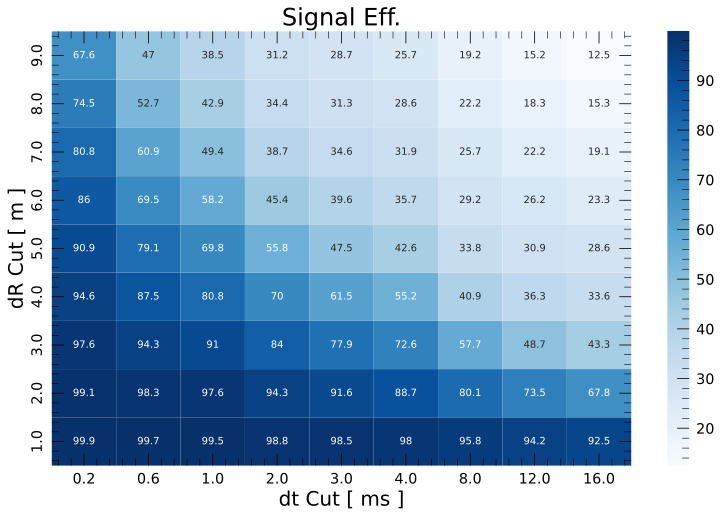

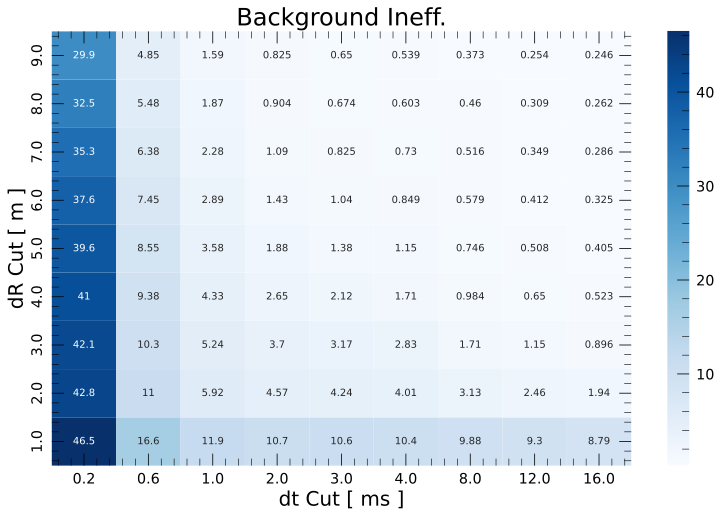

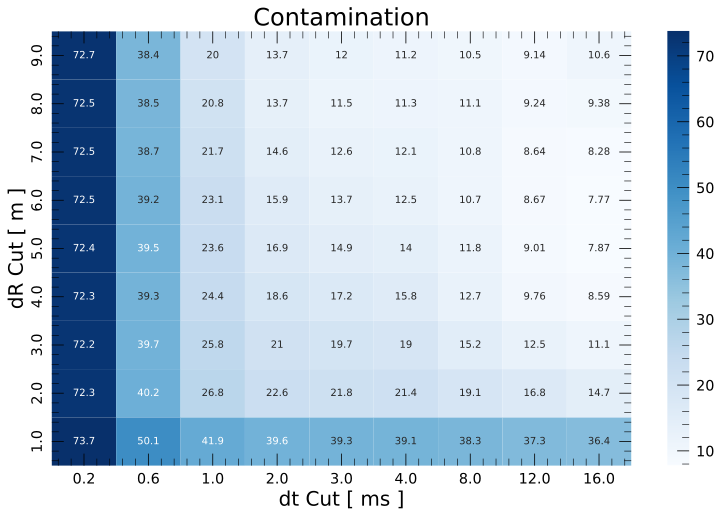

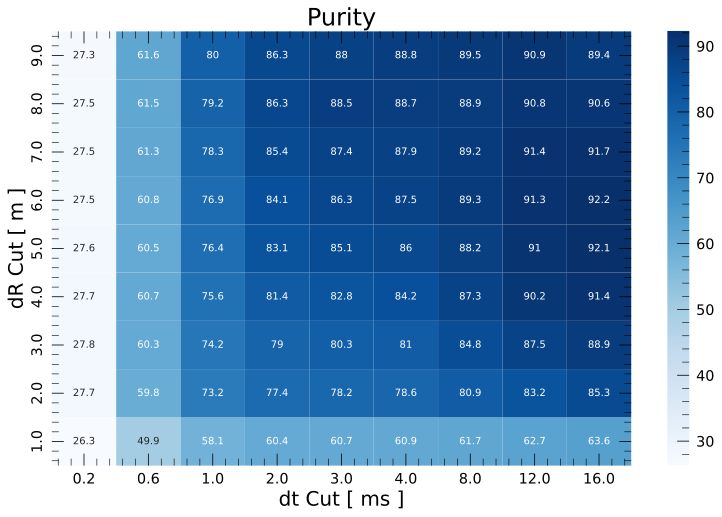

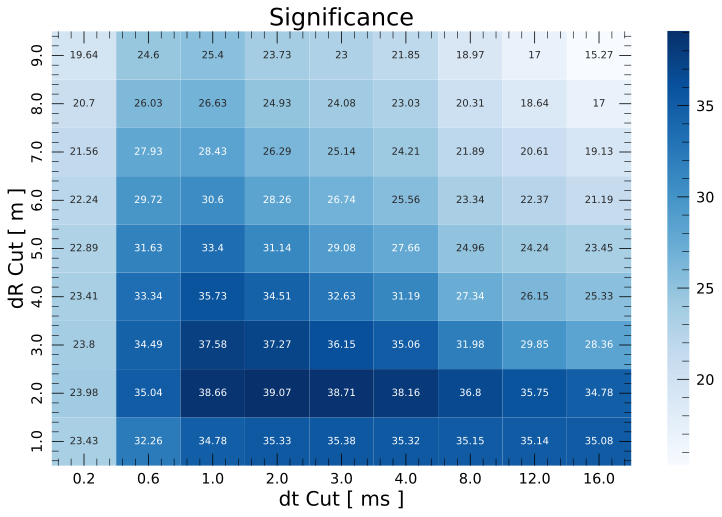

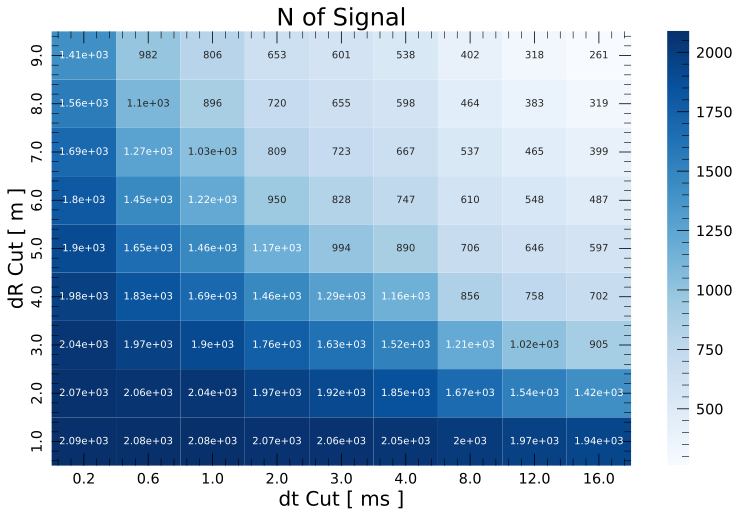

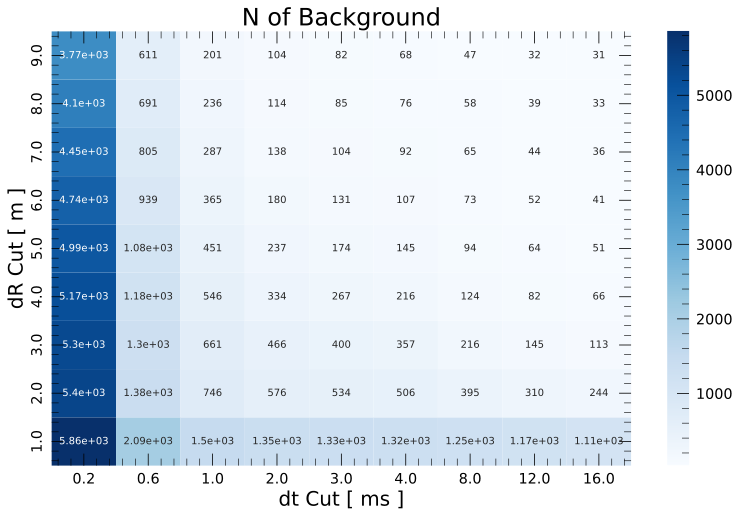

In [11]:
import seaborn as sns
v_not_plot = ["dt_cut", "dR_cut"]
v_keys_to_plot = [key for key in list( dir_eff.keys() ) if key not in v_not_plot]
print(v_keys_to_plot)
for key in v_keys_to_plot:
    plt.figure(figsize=(13,8))
    df_heatmap = df_eff.pivot_table(index="dR_cut",columns="dt_cut", values=key)
    ax = sns.heatmap( df_heatmap, cmap="Blues", annot=True, fmt=".4g" if key == "Significance" else ".3g")
    plt.title(key)
    ax.invert_yaxis()
    plt.xlabel("dt Cut [ ms ]")
    plt.ylabel("dR Cut [ m ]")

# Optimized Isolation Cut
## 1. Energy Spectrum

In [12]:
name_criteria = "Significance"
dir_IsolationTag = LoadOneFileUproot( v_files[ df_eff[name_criteria].argmax() ], name_branch="SingleSelection", return_list=False )
df_IsolationTag = pd.DataFrame.from_dict(dir_IsolationTag)
df_map["TagSingle"] = df_IsolationTag["TagSingle"]
df_residue = df_map[ index_residue ]

In [31]:
df_residue

,evtType,R,recE,TagAP,TagIBDp,TagIBDd,IBDSource,psdVal,TagPSD,TagCCp,TagCCd,CCSource,TagSingle
0,pES,6854.586489,0.212583,0,0,0,-1,0.004332,2,0,0,0,1
1,N12,15130.035355,63.653191,0,0,0,-1,0.999876,1,1,0,-1,1
4,IBDp,12277.913790,13.340494,0,1,0,-1,0.996865,1,0,0,0,0
5,IBDd,12755.635839,2.382323,0,0,1,4,0.997891,1,0,0,0,0
6,C12,4395.265212,17.160961,0,0,0,-1,0.989000,1,0,0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18663,pES,14187.729726,0.188194,0,0,0,-1,0.001276,2,0,0,0,1
18664,IBDp,11950.287108,13.805496,0,1,0,-1,0.998590,1,0,0,0,0
18665,IBDd,12043.002196,2.495589,0,0,1,18664,0.997175,1,0,0,0,0
18666,IBDp,15591.648029,18.530066,0,1,0,-1,0.999897,1,0,0,0,0


Text(0.5, 1.0, 'Comparison with Truth')

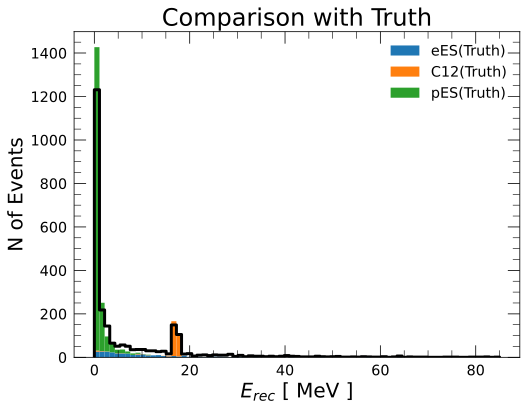

In [14]:

v2d_Erec = []
v_labels = []
E_bins = np.linspace(0,85,80)
plt.hist(df_residue[df_residue["TagSingle"]==1]["recE"],bins=E_bins,histtype="step",
         color="black", linewidth=3)
for tag_truth in v_signal_evtType:
    v2d_Erec.append( np.array(df_map["recE"][(df_map["evtType"]==tag_truth) ]) )
    v_labels.append(tag_truth+"(Truth)")

plt.hist( v2d_Erec, bins=E_bins,ls="--", stacked=True, label=v_labels)
plt.legend()
plt.xlabel("$E_{rec}$ [ MeV ]")
plt.ylabel("N of Events")
plt.title("Comparison with Truth")
# plt.semilogy()